In [1]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d aadityasinghal/facial-expression-dataset
!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/train/sad/Training_65242339.jpg  
  inflating: train/train/sad/Training_65267116.jpg  
  inflating: train/train/sad/Training_65275626.jpg  
  inflating: train/train/sad/Training_6529266.jpg  
  inflating: train/train/sad/Training_65329617.jpg  
  inflating: train/train/sad/Training_65338712.jpg  
  inflating: train/train/sad/Training_65338797.jpg  
  inflating: train/train/sad/Training_65387162.jpg  
  inflating: train/train/sad/Training_65404494.jpg  
  inflating: train/train/sad/Training_65426218.jpg  
  inflating: train/train/sad/Training_65430136.jpg  
  inflating: train/train/sad/Training_65437377.jpg  
  inflating: train/train/sad/Training_6545735.jpg  
  inflating: train/train/sad/Training_65463385.jpg  
  inflating: train/train/sad/Training_65473985.jpg  
  inflating: train/train/sad/Training_65502829.jpg  
  inflating: train/train/sad/Training_65505359.jpg  
  inflating: train/train/sad/Training_65508578.jpg

## Import Modules

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

## Load the Dataset

In [3]:
TRAIN_DIR = '/content/train/train/'
TEST_DIR = '/content/test/test/'

In [4]:
def load_dataset(directory):
    image_paths = []
    labels = []

    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)

        print(label, "Completed")

    return image_paths, labels

In [5]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

fear Completed
happy Completed
disgust Completed
angry Completed
surprise Completed
neutral Completed
sad Completed


,image,label
0,/content/train/train/sad/Training_60359406.jpg,sad
1,/content/train/train/neutral/Training_67820972...,neutral
2,/content/train/train/fear/Training_70702021.jpg,fear
3,/content/train/train/happy/Training_13287034.jpg,happy
4,/content/train/train/sad/Training_93519760.jpg,sad


In [6]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

fear Completed
happy Completed
disgust Completed
angry Completed
surprise Completed
neutral Completed
sad Completed


,image,label
0,/content/test/test/fear/PrivateTest_89884834.jpg,fear
1,/content/test/test/fear/PrivateTest_88038124.jpg,fear
2,/content/test/test/fear/PrivateTest_81756175.jpg,fear
3,/content/test/test/fear/PrivateTest_68316636.jpg,fear
4,/content/test/test/fear/PublicTest_46537524.jpg,fear


## Exploratory Data Analysis

<Axes: xlabel='count', ylabel='label'>

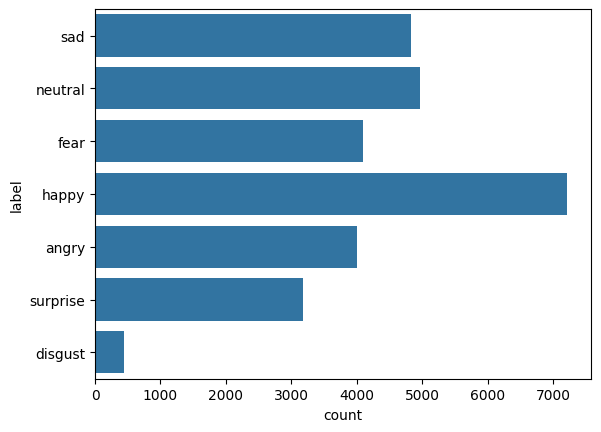

In [7]:
sns.countplot(train['label'])

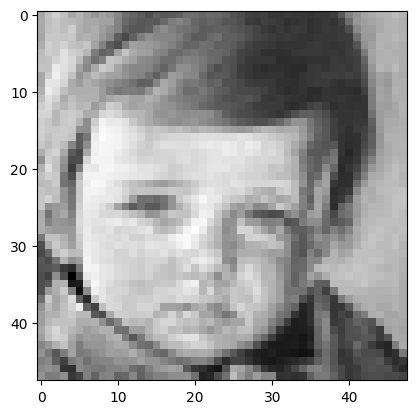

In [8]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

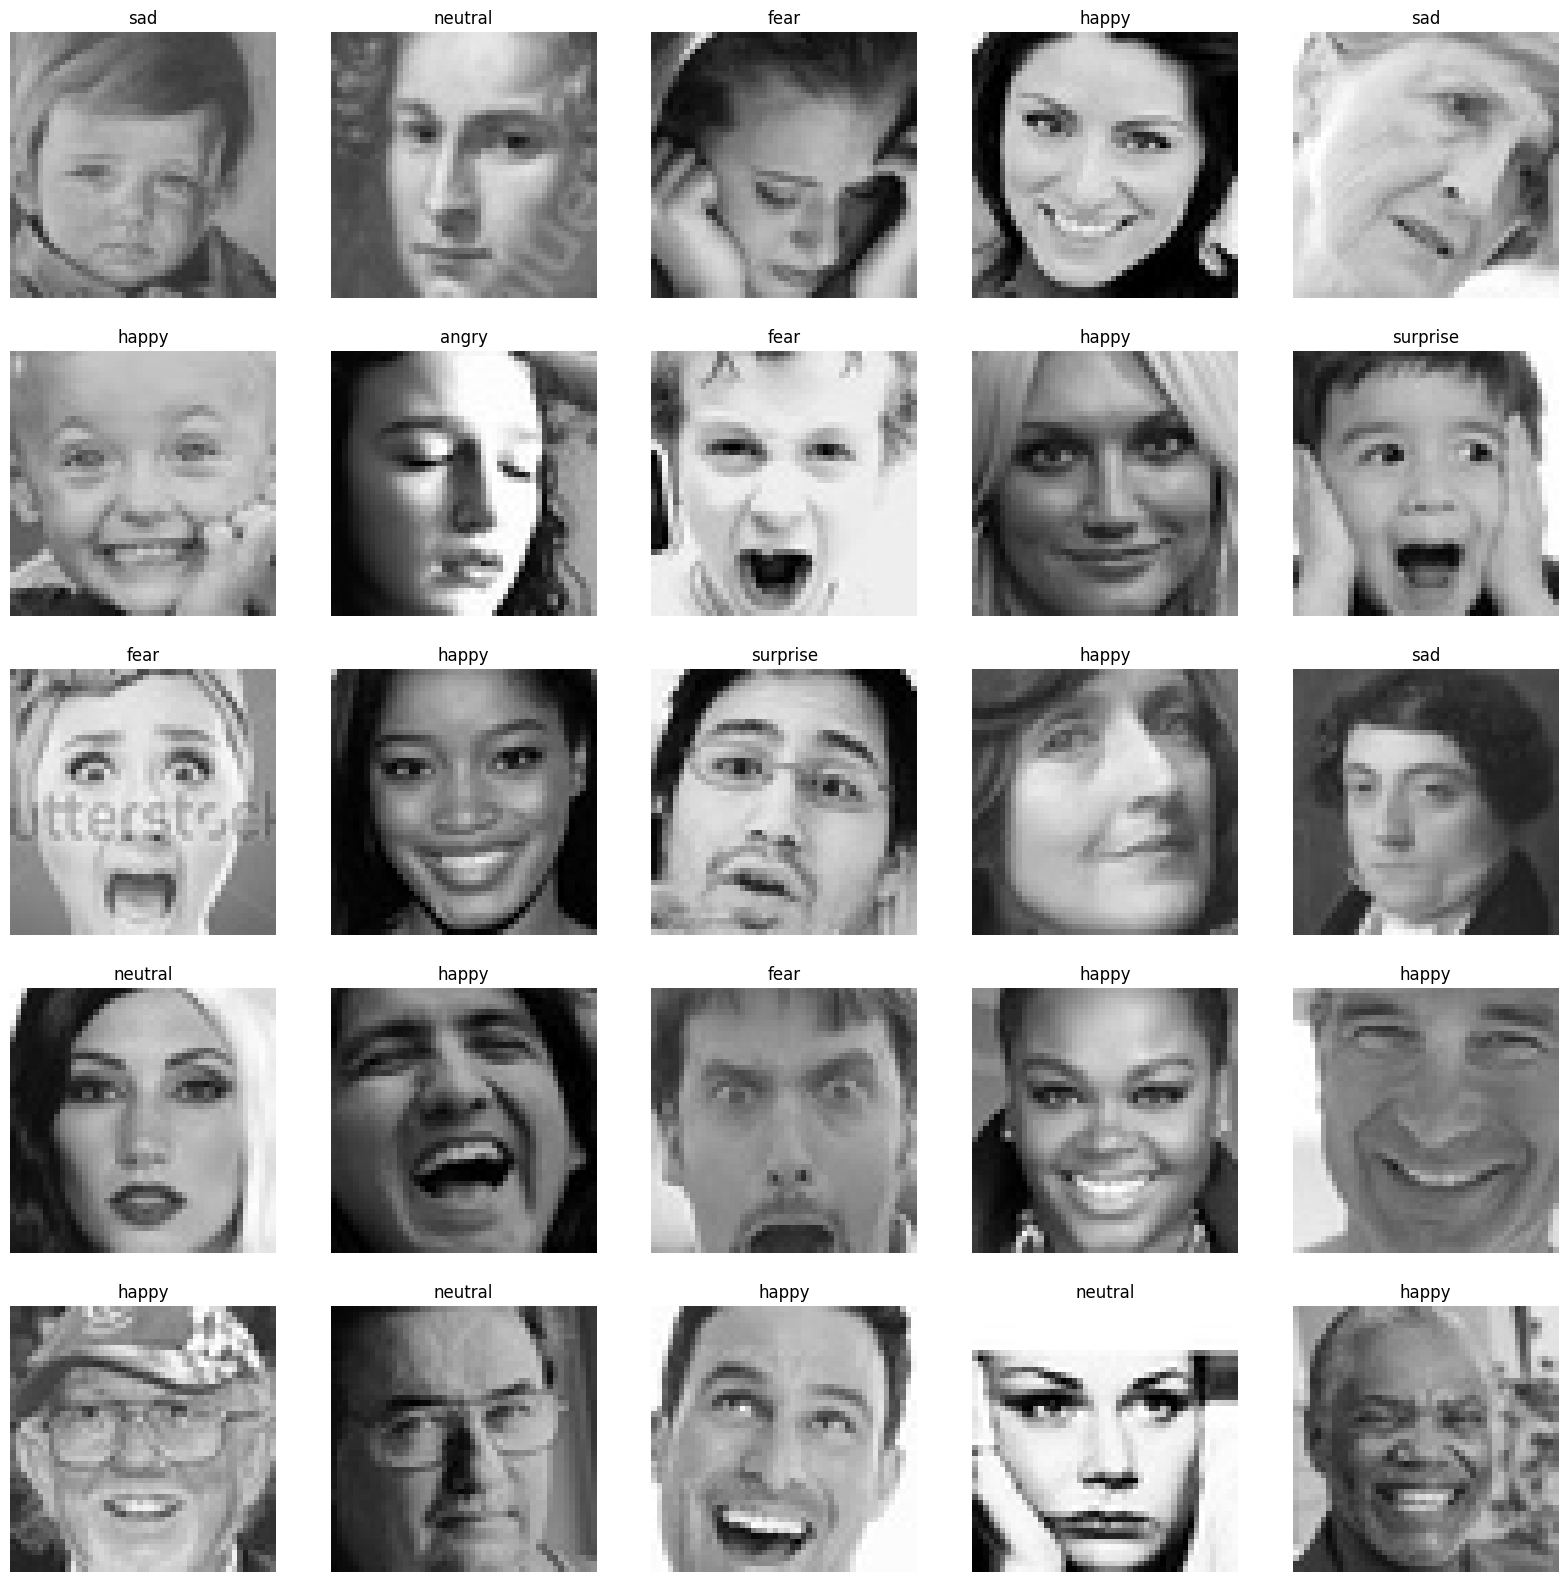

In [9]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [10]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)
    return features

In [11]:
train_features = extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [12]:
test_features = extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [13]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [16]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0.], dtype=float32)

In [17]:
# config
input_shape = (48, 48, 1)
output_class = 7

## Model Creation

In [43]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

In [45]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=250, validation_data=(x_test, y_test))

Epoch 1/250
225/225 [==============================] - 12s 52ms/step - loss: 1.7247 - accuracy: 0.2872 - val_loss: 1.6484 - val_accuracy: 0.3236
Epoch 2/250
225/225 [==============================] - 12s 52ms/step - loss: 1.6083 - accuracy: 0.3629 - val_loss: 1.4662 - val_accuracy: 0.4310
Epoch 3/250
225/225 [==============================] - 12s 52ms/step - loss: 1.4945 - accuracy: 0.4201 - val_loss: 1.3581 - val_accuracy: 0.4723
Epoch 4/250
225/225 [==============================] - 12s 52ms/step - loss: 1.4267 - accuracy: 0.4492 - val_loss: 1.3179 - val_accuracy: 0.4873
Epoch 5/250
225/225 [==============================] - 12s 51ms/step - loss: 1.3886 - accuracy: 0.4667 - val_loss: 1.2785 - val_accuracy: 0.5031
Epoch 6/250
225/225 [==============================] - 12s 51ms/step - loss: 1.3607 - accuracy: 0.4780 - val_loss: 1.2492 - val_accuracy: 0.5170
Epoch 7/250
225/225 [==============================] - 12s 51ms/step - loss: 1.3300 - accuracy: 0.4910 - val_loss: 1.2322 - val_ac

## Plot the Results

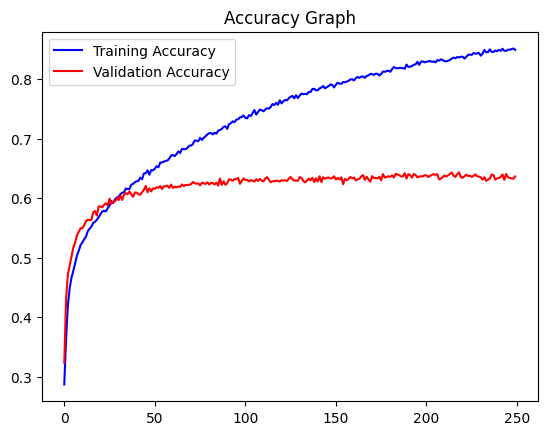

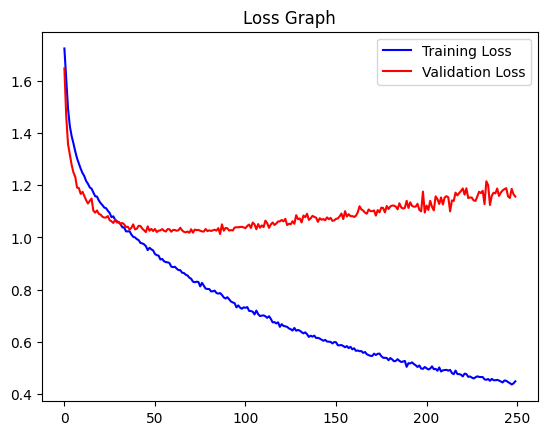

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: happy
1/1 [==============================] - 0s 17ms/step
Predicted Output: happy


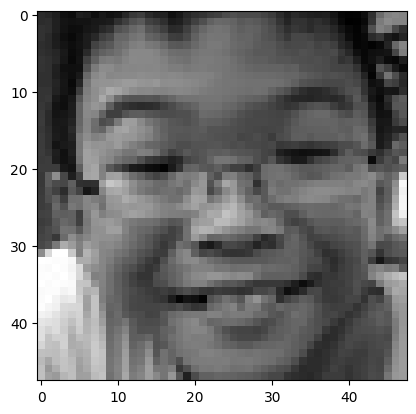

In [53]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: happy
1/1 [==============================] - 0s 31ms/step
Predicted Output: happy


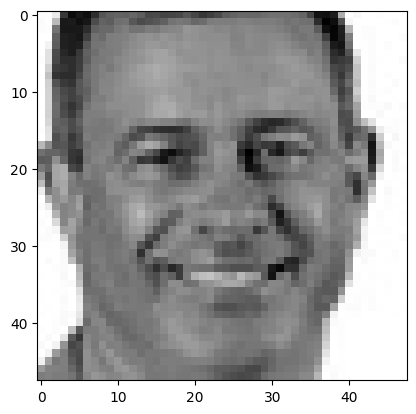

In [56]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

Original Output: neutral
1/1 [==============================] - 0s 17ms/step
Predicted Output: neutral


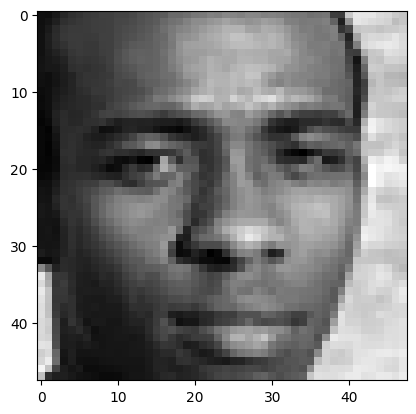

In [58]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray');

In [59]:
model.save("model3.h5")